In [1]:
# @title Install dependencies
# @markdown

#!pip install ipywidgets matplotlib torch torchvision tqdm hashlib requests

In [2]:
# Standard Libraries for file and operating system operations, and web requests
import hashlib
import logging
import os
import random
import requests
import zipfile
from zipfile import ZipFile

# Data Handling and Visualization Libraries
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import io
from sklearn.model_selection import train_test_split

# Deep Learning Libraries
import torch
import torchvision
from scipy.spatial.distance import cdist
from torchvision import transforms
from torchvision.transforms import ToPILImage

# IPython Display & Widgets for interactive controls in Jupyter notebooks
from IPython.display import clear_output, display
import ipywidgets as widgets

# Additional Utilities
from tqdm import tqdm

In [3]:
# @title Figure settings
# @markdown

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle") # update this to match your course

In [4]:
# @title Plotting functions
# @markdown

def display_images(probe, options):
    # Open the probe image and the option images
    probe_image = Image.open(probe)
    option_images = [Image.open(img_path) for img_path in options]
    
    # Create a figure with 1 row for the probe, an empty row, and a 3x3 grid for the options
    fig = plt.figure(figsize=(15, 12))  # Adjust figure size to accommodate extra space
    
    # Add the probe image to the top of the figure with a red border
    ax_probe = fig.add_subplot(5, 3, (1, 3))  # Span the probe across the top 3 columns
    ax_probe.imshow(probe_image)
    ax_probe.axis('off')
    rect = patches.Rectangle((0, 0), probe_image.width-1, probe_image.height-1, linewidth=2, edgecolor='r', facecolor='none')
    ax_probe.add_patch(rect)
    
    # Add text "New Concept" above the probe image
    ax_probe.set_title("New Concept", color='blue', fontsize=14)

    # Add text "New Examples" above the 3x3 grid (two rows below the probe)
    fig.text(0.5, 0.6, 'New Examples', ha='center', va='center', fontsize=14)

    # Adjust the function to correctly position the 3x3 grid of option images with a row of white space
    for index, img in enumerate(option_images):
        row = index // 3 + 2  # Calculate row in the 3x3 grid, starting from 2 below the probe to leave a white row
        col = index % 3 + 1   # Calculate column in the 3x3 grid
        ax_option = fig.add_subplot(5, 3, row * 3 + col)  # Position in the grid with extra row for white space
        ax_option.imshow(img)
        ax_option.axis('off')

    plt.tight_layout()
    plt.show()



In [5]:
#@title Data retrieval
# @markdown

# Variables for file and download URL
fname = "omniglot-py.zip"
url = "https://osf.io/bazxp/download"  # Ensure this is the correct download URL
expected_md5 = "f7a4011f5c25460c6d95ee1428e377ed"

def download_file(url, filename):
    """Downloads file from the given URL and saves it locally."""
    try:
        # Attempt to download the file
        r = requests.get(url, stream=True)  # Use stream to download large files
        r.raise_for_status()  # Raise an HTTPError for bad responses
        with open(filename, "wb") as fid:
            for chunk in r.iter_content(chunk_size=8192):
                fid.write(chunk)
        return True
    except requests.RequestException as e:
        print(f"!!! Failed to download data: {e} !!!")
        return False

def verify_file_md5(filename, expected_md5):
    """Verifies the file's MD5 checksum."""
    hash_md5 = hashlib.md5()
    with open(filename, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest() == expected_md5

def extract_zip_file(filename, extract_to='data'):
    """Extracts the ZIP file to the specified directory."""
    try:
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"File extracted successfully to {extract_to}")
    except zipfile.BadZipFile:
        print("!!! The ZIP file is corrupted or not a zip file !!!")

# Check if file already exists
if not os.path.isfile(fname):
    if download_file(url, fname):
        print("Download successful.")
        if verify_file_md5(fname, expected_md5):
            print("MD5 checksum verified.")
            extract_zip_file(fname)  # Specify your desired extraction directory if needed
        else:
            print("!!! Data download appears corrupted !!!")
else:
    print("File already exists. Verifying MD5 checksum...")
    if verify_file_md5(fname, expected_md5):
        print("MD5 checksum verified.")
        # Optionally, you could extract the file here if it hasn't been extracted yet
    else:
        print("!!! The existing file appears corrupted !!!")

File already exists. Verifying MD5 checksum...
MD5 checksum verified.


In [6]:
#@title Helper functions
# @markdown

def select_random_images(base_path, exclude_path, num_images=9):
    chosen_images = []
    all_languages = [lang for lang in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, lang))]
    while len(chosen_images) < num_images:
        language = random.choice(all_languages)
        language_path = os.path.join(base_path, language)
        if language_path == exclude_path:
            continue
        all_characters = [char for char in os.listdir(language_path) if os.path.isdir(os.path.join(language_path, char))]
        if not all_characters:
            continue
        character = random.choice(all_characters)
        character_path = os.path.join(language_path, character)
        all_images = [img for img in os.listdir(character_path) if img.endswith('.png')]
        if not all_images:
            continue
        image_file = random.choice(all_images)
        image_path = os.path.join(character_path, image_file)
        if image_path not in chosen_images:
            chosen_images.append(image_path)
    return chosen_images

def run_trial(base_path, num_trials):
    for _ in range(num_trials):
        # Selecting a random language and character for the probe and correct answer
        languages = [lang for lang in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, lang))]
        selected_language = random.choice(languages)
        language_path = os.path.join(base_path, selected_language)
        characters = [char for char in os.listdir(language_path) if os.path.isdir(os.path.join(language_path, char))]
        selected_character = random.choice(characters)
        character_path = os.path.join(language_path, selected_character)
        
        # Selecting probe and correct answer images
        images = [img for img in os.listdir(character_path) if img.endswith('.png')]
        probe_image_path, correct_answer_image_path = random.sample(images, 2)
        probe_image_path = os.path.join(character_path, probe_image_path)
        correct_answer_image_path = os.path.join(character_path, correct_answer_image_path)
        
        # Selecting wrong answers
        wrong_answers = select_random_images(base_path, character_path, num_images=8)
        
        # Randomly placing the correct answer among the wrong answers
        options = wrong_answers
        options.insert(random.randint(0, len(options)), correct_answer_image_path)
        
        # Displaying images
        display_images(probe_image_path, options)

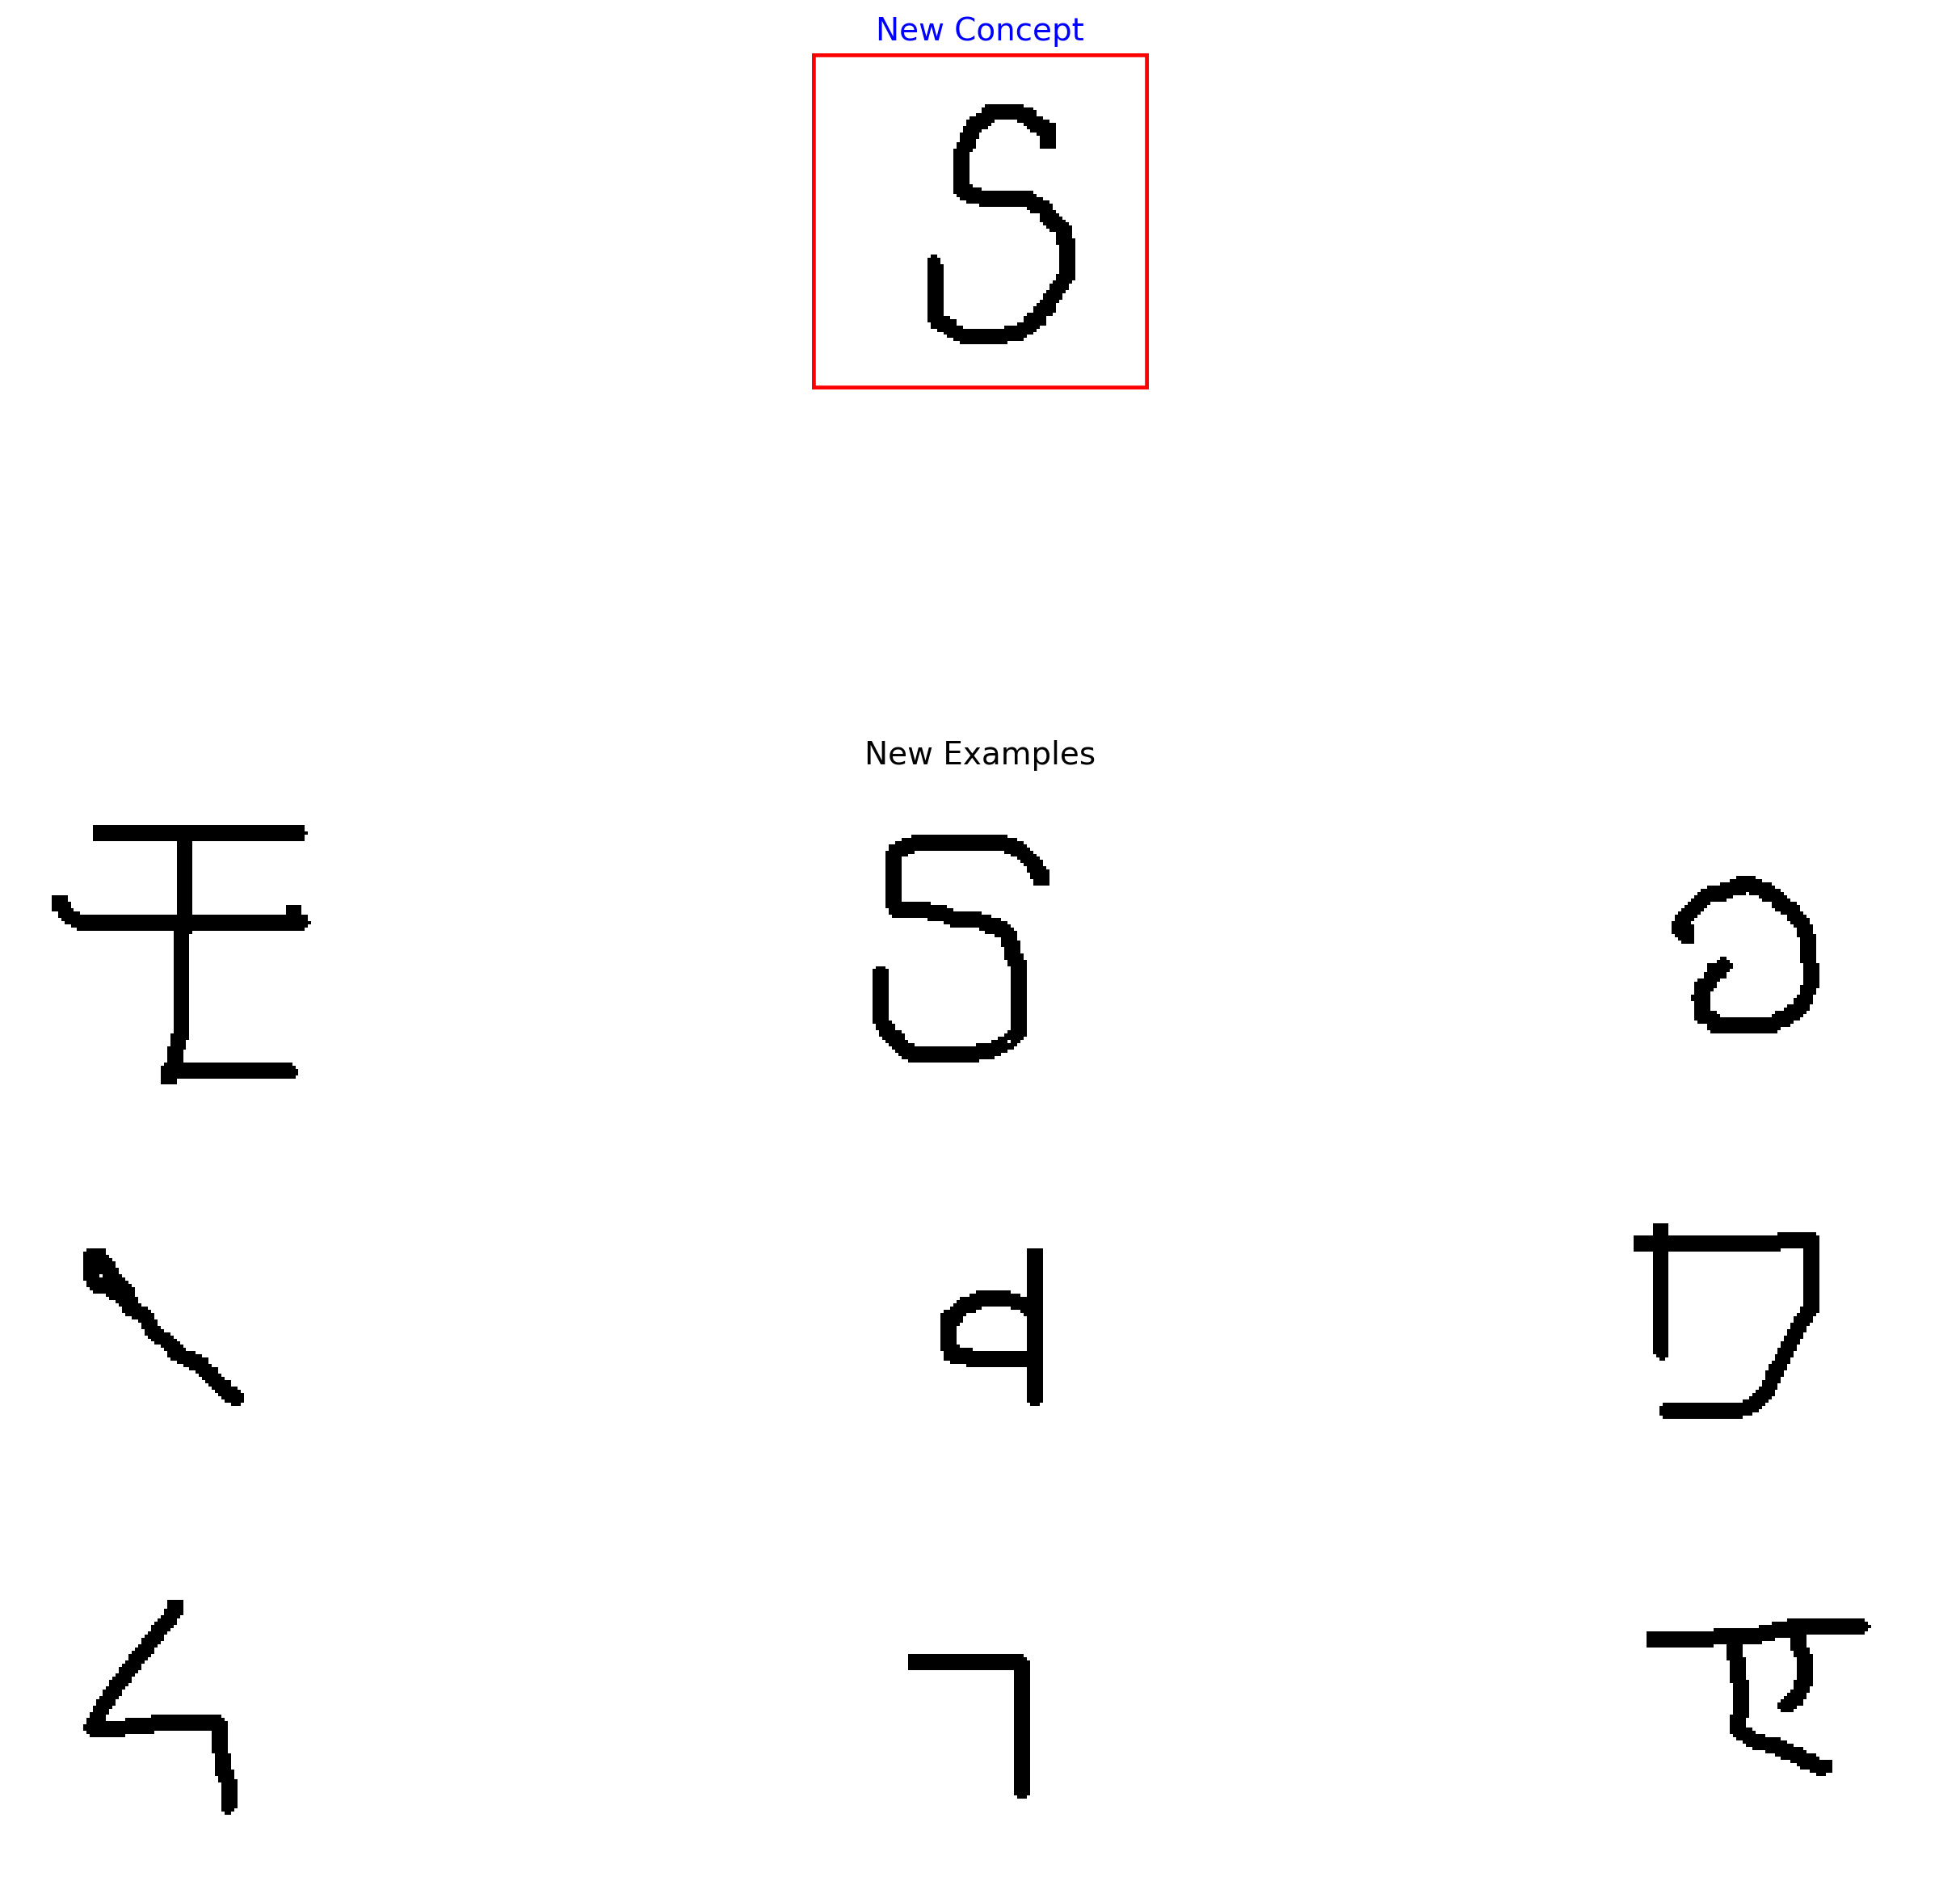

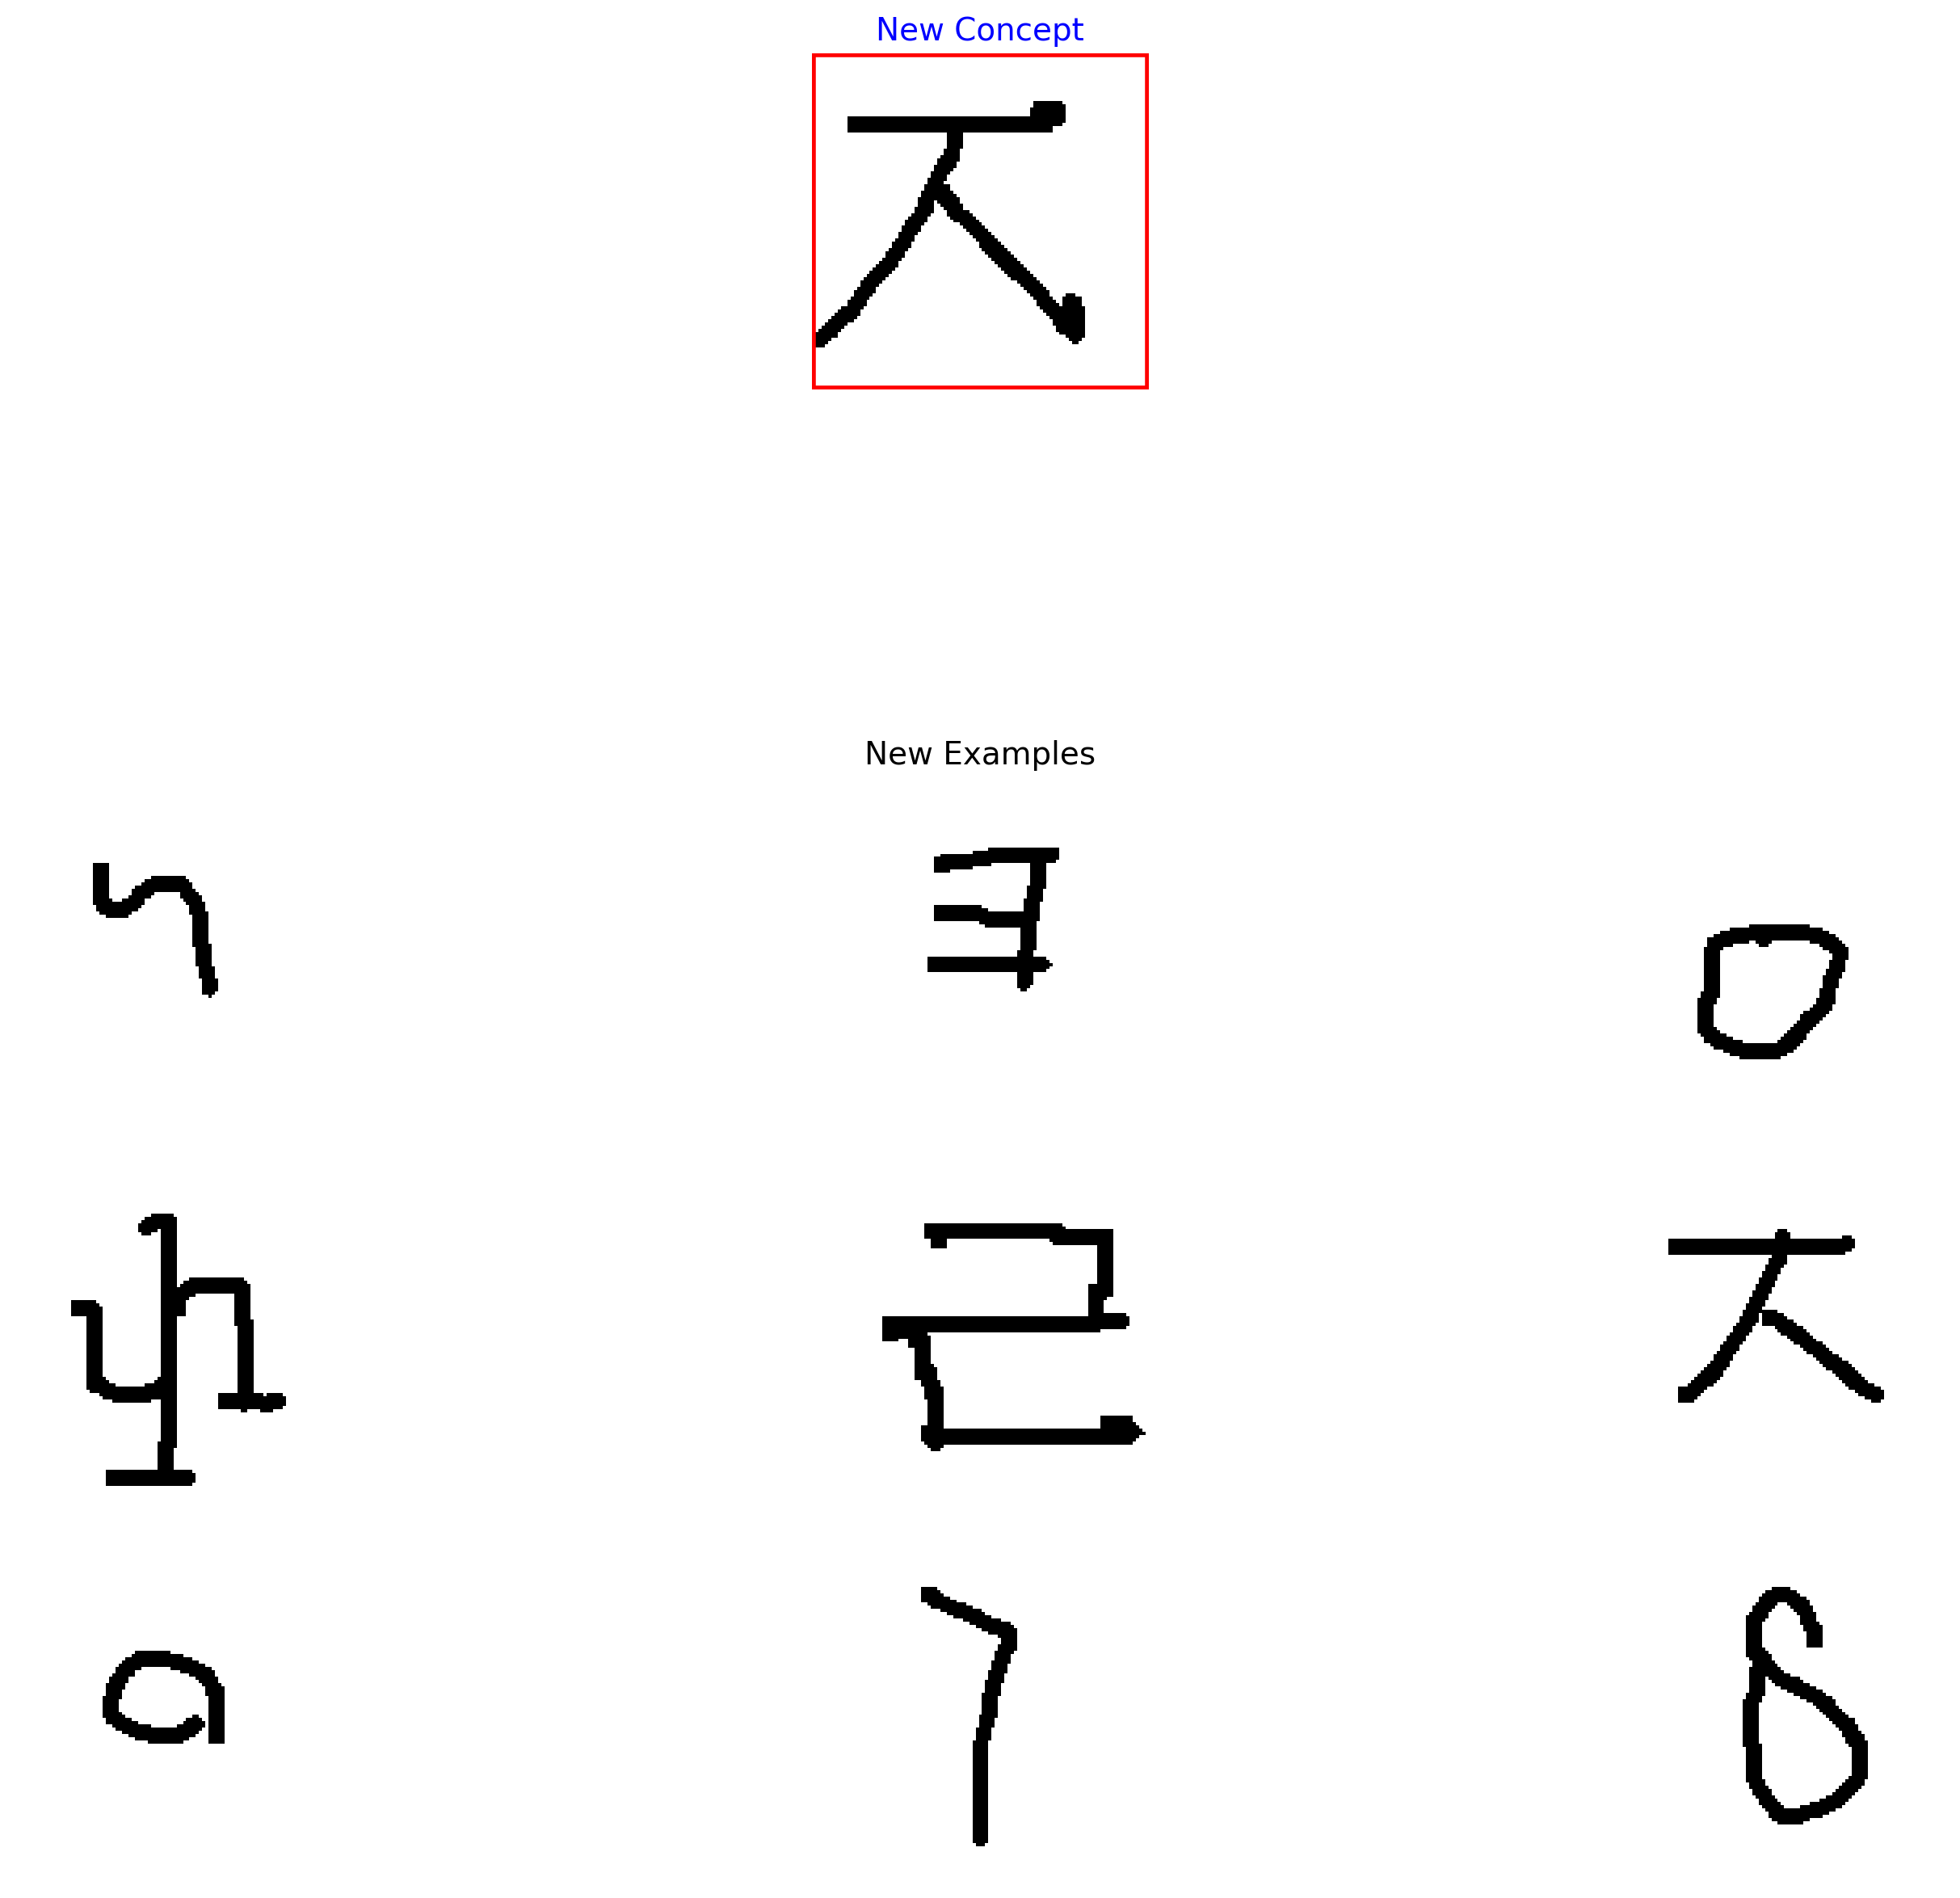

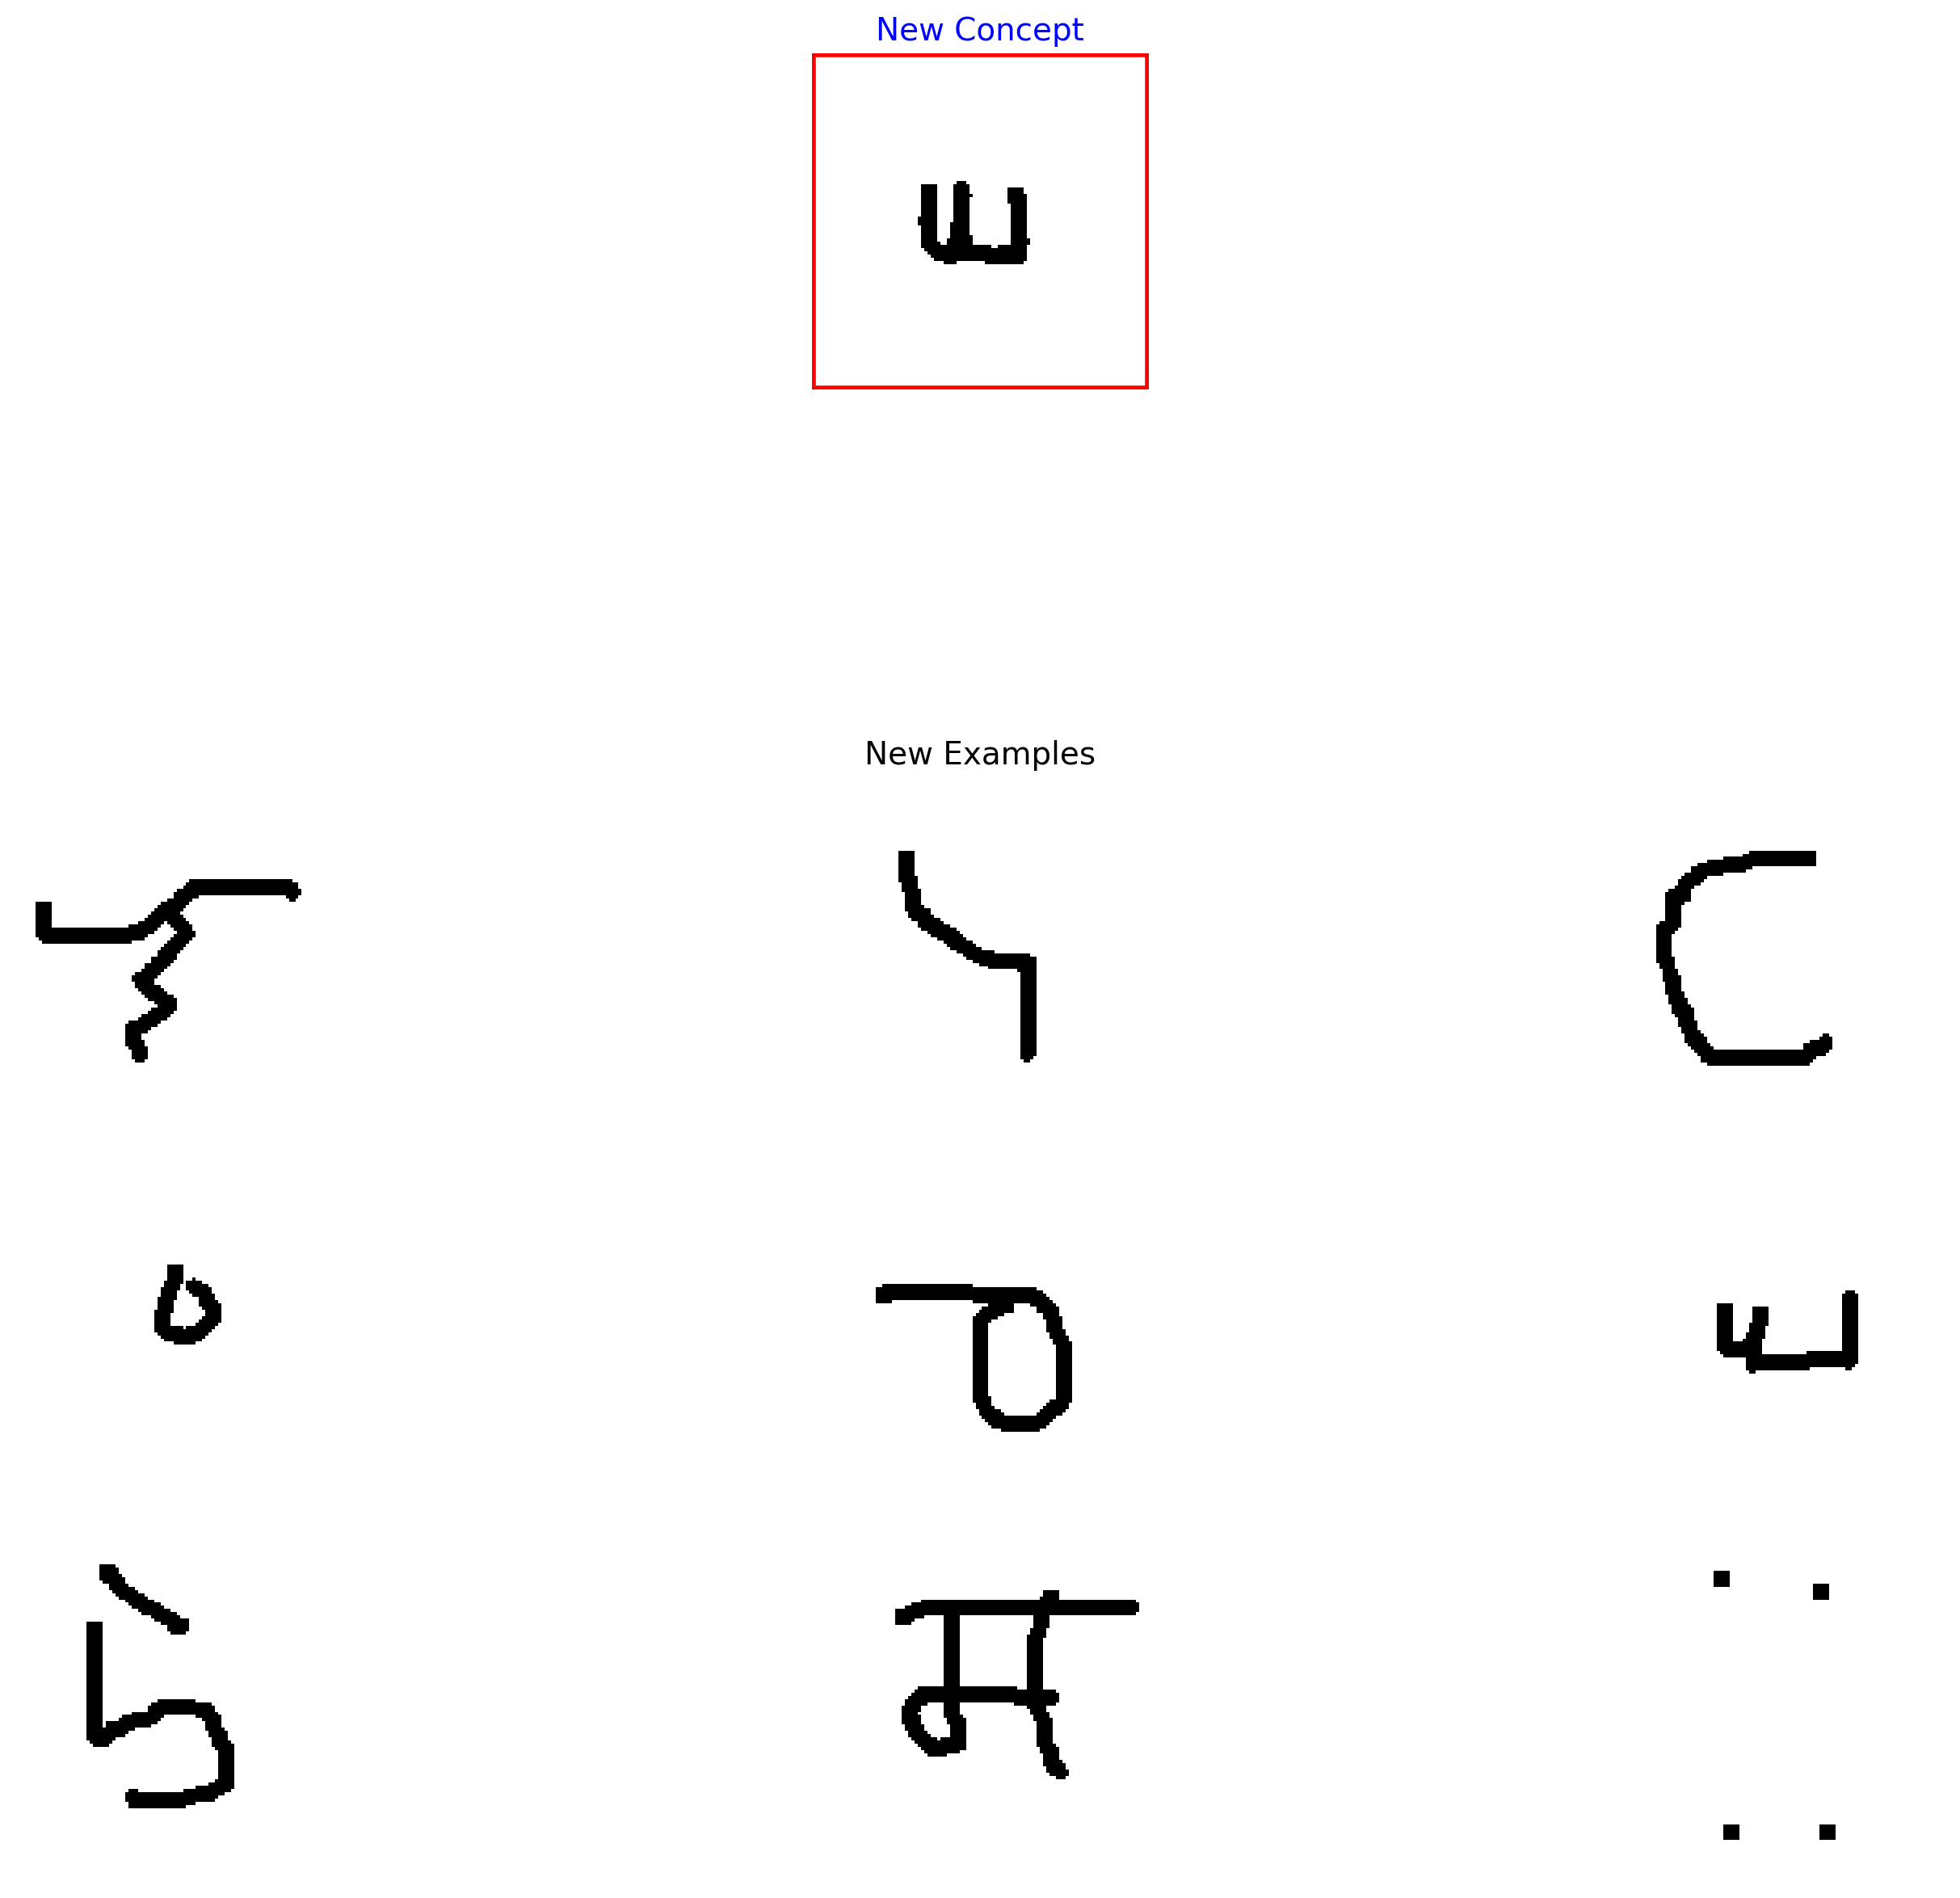

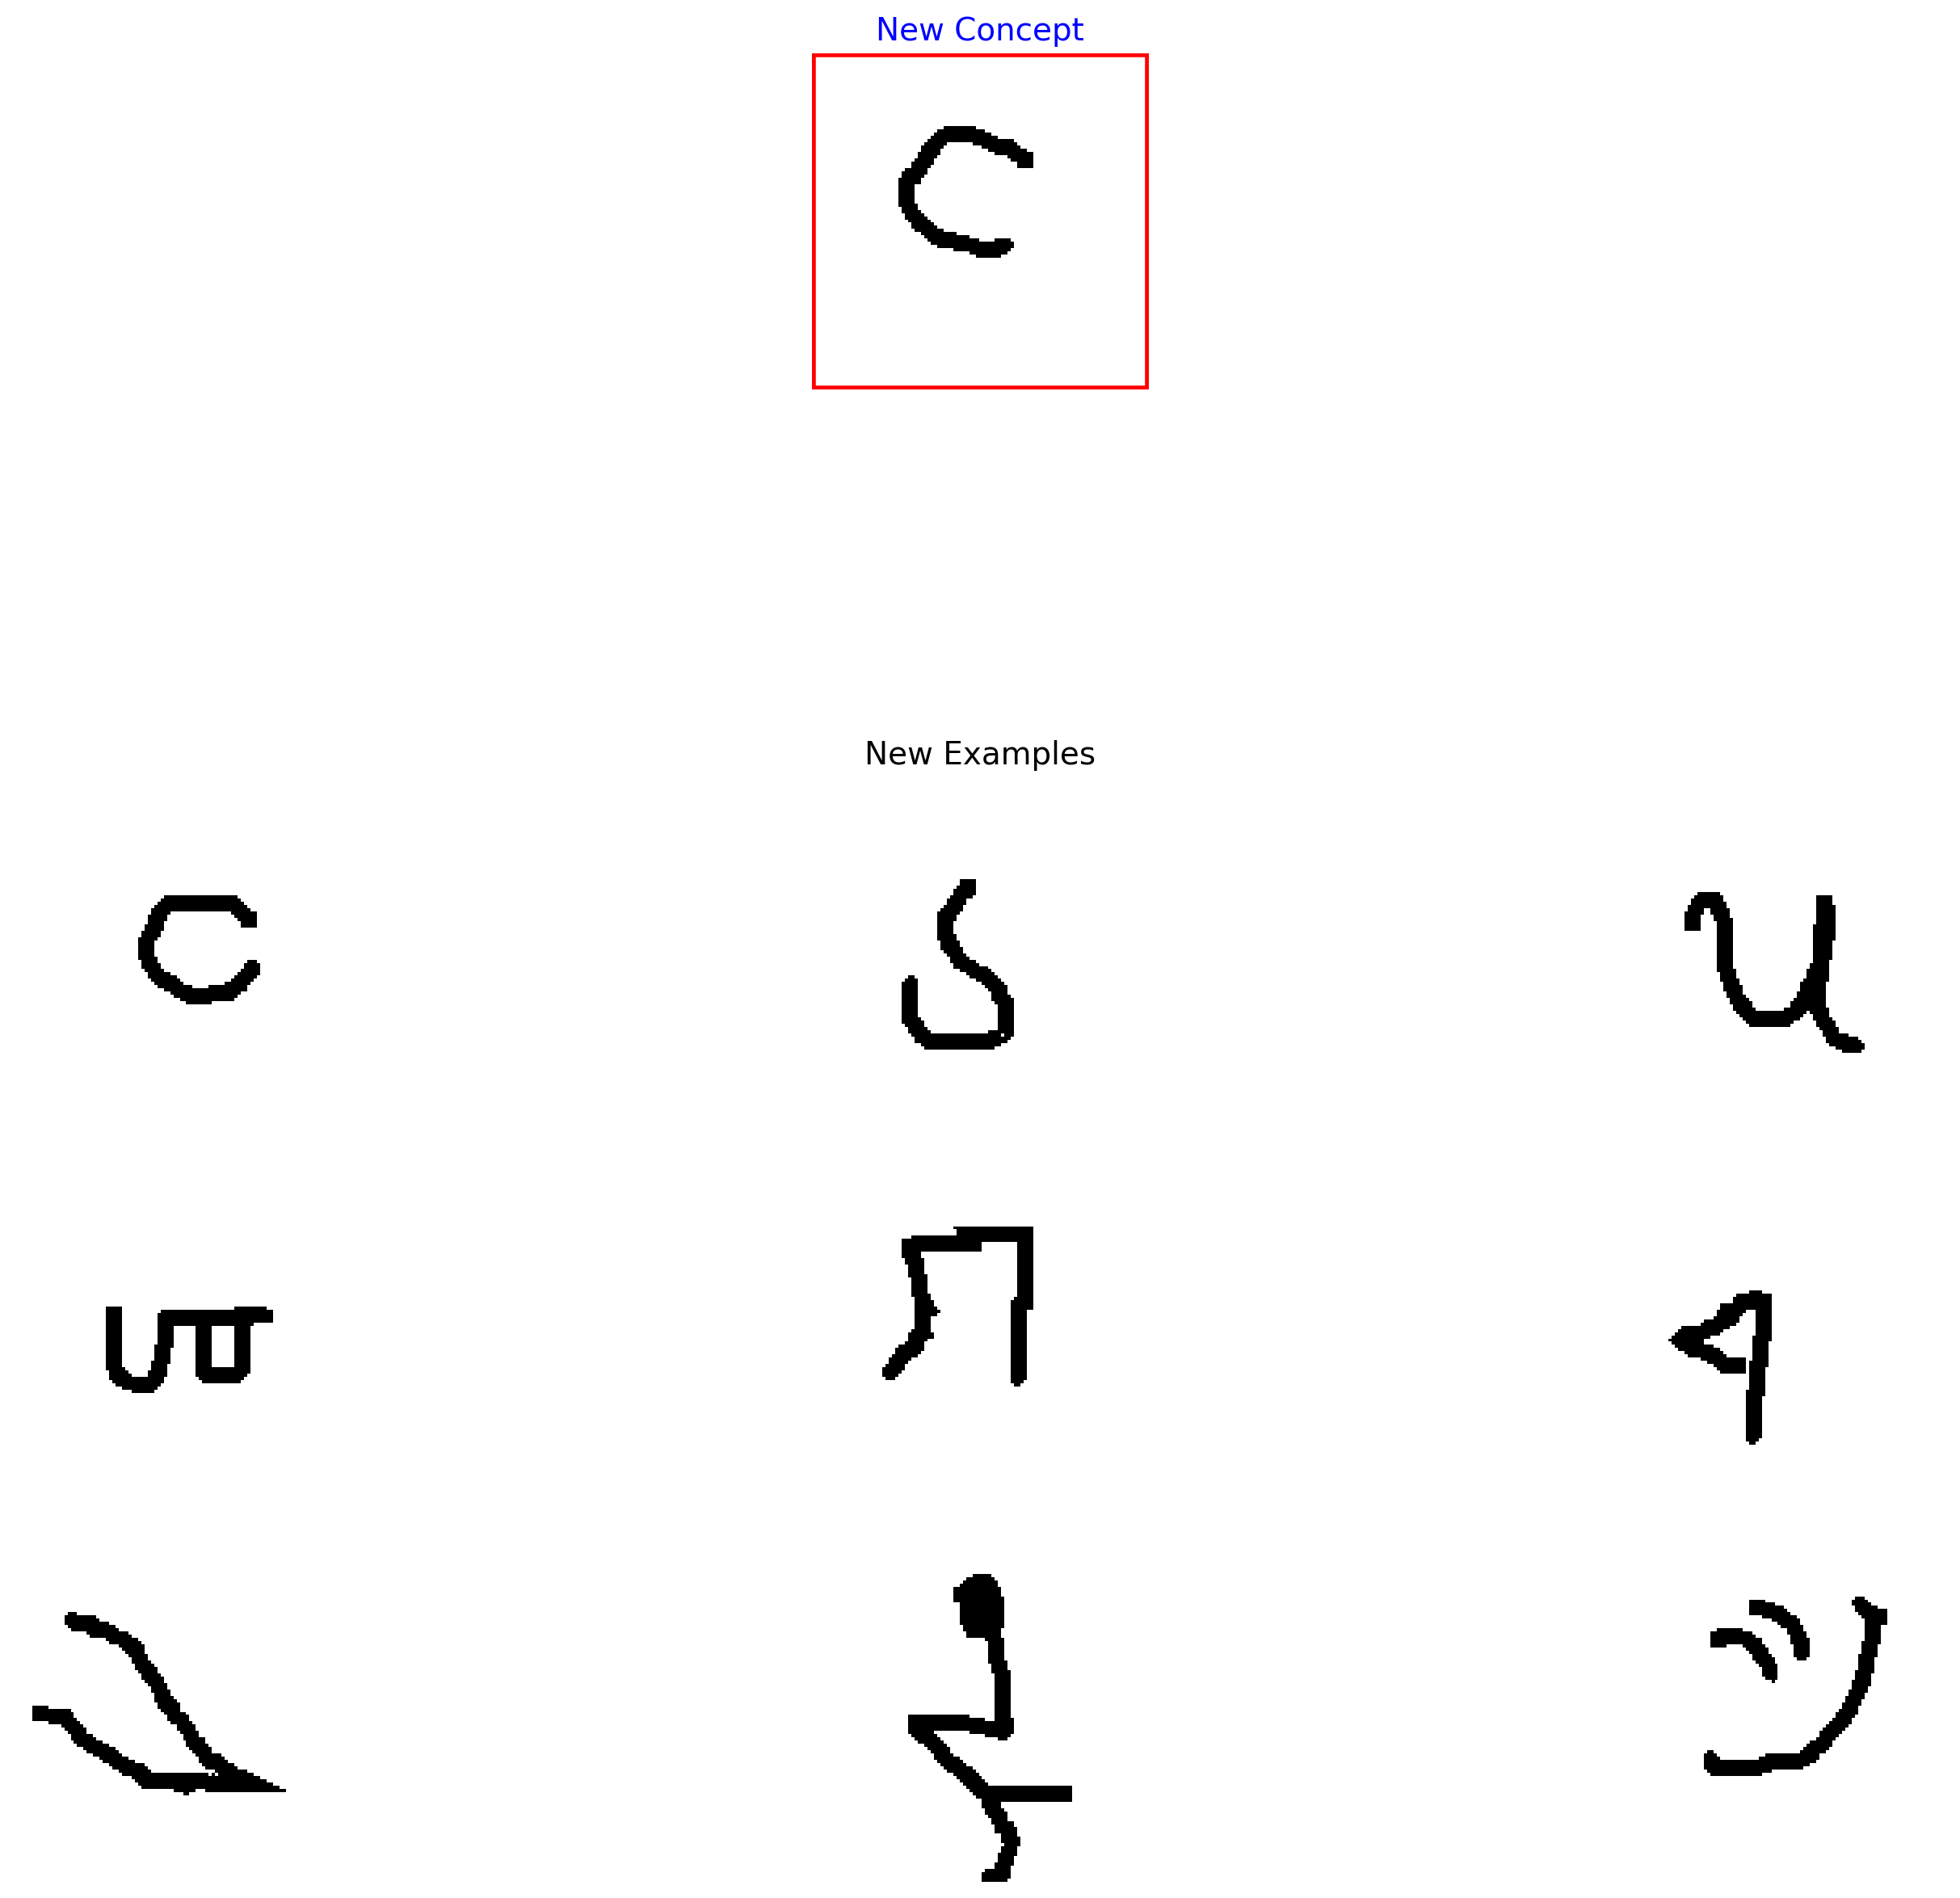

In [8]:
# Paths
base_path = "omniglot_data/omniglot-py/images_background"

# Running the trial
run_trial(base_path, num_trials=5)